<a href="https://www.kaggle.com/code/alishohadaee/ml-ul-human-activity-recognition?scriptVersionId=167289069" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## <center> Unsupervised learning - Samsung Human Activity Recognition

In this task, we will look at how data dimensionality reduction and clustering methods work. At the same time, we'll practice solving classification task again.

We will work with the [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. Download the data [here](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). The data comes from accelerometers and gyros of Samsung Galaxy S3 mobile phones ( you can find more info about the features using the link above), the type of activity of a person with a phone in his/her pocket is also known – whether he/she walked, stood, lay, sat or walked up or down the stairs.

First, we pretend that the type of activity is unknown to us, and we will try to cluster people purely on the basis of available features. Then we solve the problem of determining the type of physical activity as a classification problem.

Fill the code where needed ("Your code is here") and answer the questions in the [web form](https://docs.google.com/forms/d/1wBf5UoRndv6PpzIwYnM9f0ysoGa4Yqcqle-HBlBP5QQ/edit).

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
# change this if necessary
PATH_TO_SAMSUNG_DATA = "../input"

In [3]:
X_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA,
                                  "samsung_train_labels.txt")).astype(int)

X_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_test.txt"))
y_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA,
                                  "samsung_test_labels.txt")).astype(int)

In [4]:
# Checking dimensions
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

For clustering, we do not need a target vector, so we'll work with the combination of training and test samples. Merge `X_train` with `X_test`, and `y_train` with `y_test`.

In [5]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

Define the number of unique values of the labels of the target class.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

This says that we have 6 categories for the data

In [7]:
n_classes = np.unique(y).size
n_classes

6

[These labels correspond to:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 – walking
- 2 – walking upstairs
- 3 – walking downstairs
- 4 – sitting
- 5 – standing
- 6 – laying down

------------------------------

## PCA - Dimensionality Reduction

Scale the sample using `StandardScaler` with default parameters.

In [8]:
# Scaler object
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the original (scaled) data. Use the scaled dataset and fix `random_state` (RANDOM_STATE constant).

In [9]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

**Question 1:** <br>

What is the minimum number of principal components required to cover the 90% of the variance of the original (scaled) data?

In [10]:
X_pca.shape

(10299, 65)

Number of components to explain 90% of variance: 65


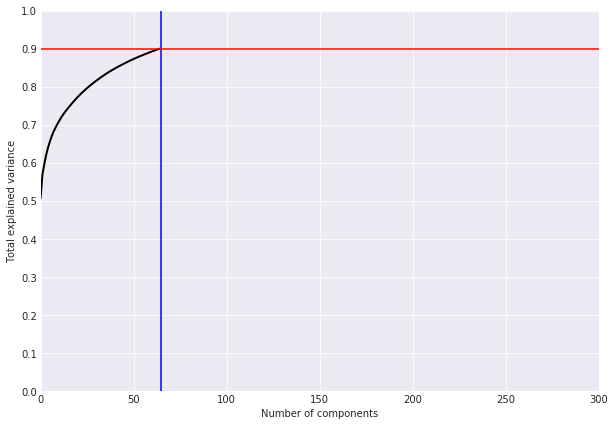

In [11]:
# Determine the number of principal components needed to explain at least 90% of the variance
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
n_components_90_percent = np.argmax(explained_variance_ratio_cumsum >= 0.90) + 1

print("Number of components to explain 90% of variance:", n_components_90_percent)

# Retain only the selected principal components
X_pca_90_percent = X_pca[:, :n_components_90_percent]

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 300)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(65, c='b')
plt.axhline(0.9, c='r')
plt.show();

**Question 2:**<br>
What percentage of the variance is covered by the first principal component?

In [12]:
print("{} component: {}% of initial variance"
      .format(1, round(100 * pca.explained_variance_ratio_[0], 2)))

1 component: 50.74% of initial variance


Around 51% is covered by the first component.

__**Visualized two components**__
- Visualize data in projection on the first two principal components.

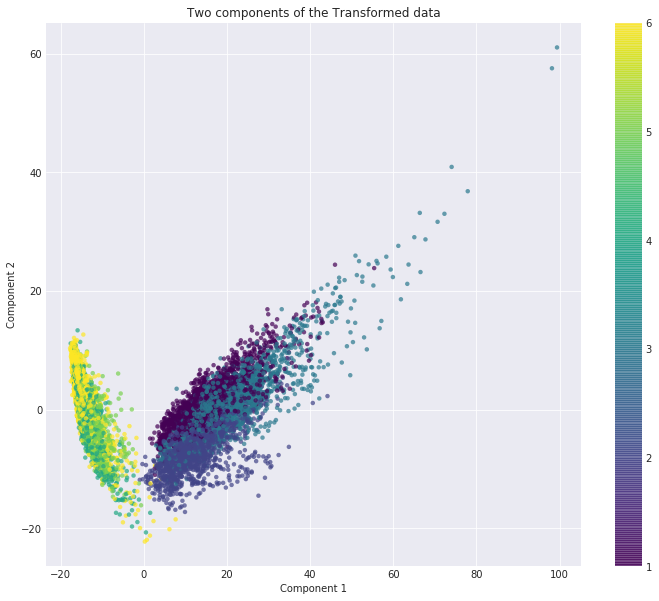

In [13]:
plt.figure(figsize=(12, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=20, cmap='viridis');
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar()
plt.title("Two components of the Transformed data")
plt.show()

**Question 3:**<br>
If everything worked out correctly, you will see a number of clusters, almost perfectly separated from each other. What types of activity are included in these clusters? <br>

- From the visualization we can understand that ther are 2 clusters: (walking, walking upstairs, walking downstairs ) and (sitting, standing, laying).

------------------------------

## KMeans Clustring

Perform clustering with the `KMeans` method, training the model on data with reduced dimensionality (by PCA). In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be looking for.

Options:

- **n_clusters** = n_classes (number of unique labels of the target class)
- **n_init** = 100
- **random_state** = RANDOM_STATE (for reproducibility of the result)

Other parameters should have default values.

In [14]:
kmeans = KMeans(n_clusters=6, n_init=100, 
                random_state=RANDOM_STATE)  ## As we already know that we have 6 categories
kmeans.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=17, tol=0.0001, verbose=0)

Visualize data in projection on the first two principal components. Color the dots according to the clusters obtained.

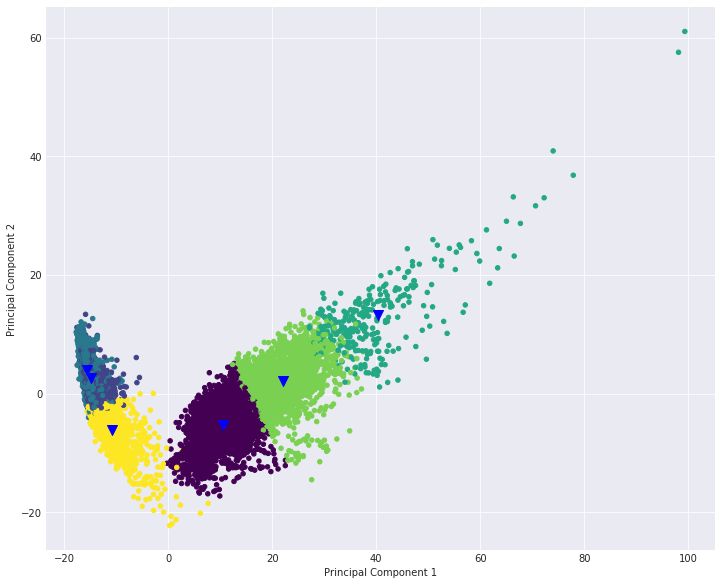

In [15]:
plt.figure(figsize=(12, 10))

cluster_labels = kmeans.labels_
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis');

# Plot cluster centers
cluster_centers = kmeans.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', marker='v', s=100, alpha=1)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Look at the correspondence between the cluster marks and the original class labels and what kinds of activities the `KMeans` algorithm is confused at.

In the below code you see the **crosstab method**, also known as contingency table or cross-tabulation, which is a useful tool in data analysis to summarize and compare the relationship between two or more categorical variables

In [16]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,903,0,0,78,741,0,1722
going up the stairs,1241,0,0,5,296,2,1544
going down the stairs,320,0,0,196,890,0,1406
sitting,1,1235,91,0,0,450,1777
standing,0,1344,0,0,0,562,1906
laying,5,52,1558,0,0,329,1944
all,2470,2631,1649,279,1927,1343,10299


We see that for each class (i.e., each activity) there are several clusters. Let's look at the maximum percentage of objects in a class that are assigned to a single cluster. This will be a simple metric that characterizes how easily the class is separated from others when clustering.

Example: if for class "walking downstairs" (with 1406 instances belonging to it), the distribution of clusters is:
 - cluster 1 - 900
 - cluster 3 - 500
 - cluster 6 - 6,
 
then such a share will be 900/1406 $ \approx $ 0.64.
 

**Question 4:** <br>
Which activity is separated from the rest better than others based on the simple metric described above? <br>


In [17]:
print("Approximate correct cluster for Walking is: ", 90300//1722)
print("Approximate correct cluster for Upstairs is: ", 124100//1544)
print("Approximate correct cluster for Downstairs is: ", 89000//1406)
print("Approximate correct cluster for Sitting is: ", 123500//1777)
print("Approximate correct cluster for Standing is: ", 134400//1906)
print("Approximate correct cluster for Laying is: ", 155800//1944)

Approximate correct cluster for Walking is:  52
Approximate correct cluster for Upstairs is:  80
Approximate correct cluster for Downstairs is:  63
Approximate correct cluster for Sitting is:  69
Approximate correct cluster for Standing is:  70
Approximate correct cluster for Laying is:  80


OR

In [18]:
pd.Series(tab.iloc[:-1,:-1].max(axis=1).values / 
          tab.iloc[:-1,-1].values, index=tab.index[:-1])

walking                  0.524390
going up the stairs      0.803756
going down the stairs    0.633001
sitting                  0.694992
standing                 0.705142
laying                   0.801440
dtype: float64

It can be seen that kMeans does not distinguish activities very well. Use the elbow method to select the optimal number of clusters. Parameters of the algorithm and the data we use are the same as before, we change only `n_clusters`.

In [19]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

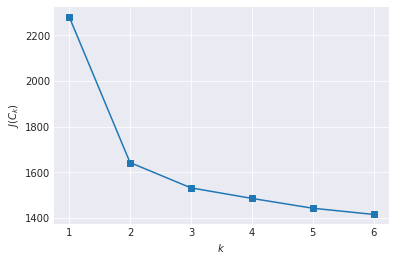

In [20]:
plt.plot(range(1, n_classes + 1), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

We calculate  D(k)
 , as described in this article in the section "Selecting the number of clusters for kMeans".

In [21]:
d = {}
for k in range(2, 6):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])
    
d

{2: 0.17344753560094228,
 3: 0.41688528047777845,
 4: 0.932335497569889,
 5: 0.6301990039713901}

**Question 5:** <br>
How many clusters can we choose according to the elbow method? <br>

**Answer:**
2 is the optimal number of clusters here in this case.

------------------------

## Agglomerative Clustering
Let's try another clustering algorithm, described in the article – agglomerative clustering.

In the below code:
- The **linkage** argument determines the metric used to compute the proximity between clusters.
    - 'ward': This linkage criterion minimizes the variance of the clusters being merged. It is typically used with Euclidean distance and is considered the default choice when using agglomerative clustering.
    - 'complete': This linkage criterion measures the maximum distance between all points in the two clusters. It tends to produce compact clusters but can be sensitive to outliers.
    - 'average': This linkage criterion computes the average of the distances between all pairs of points in the two clusters. It tends to produce more balanced clusters and is less sensitive to outliers compared to 'complete' linkage. 
    - 'single': This linkage criterion measures the minimum distance between all points in the two clusters. It can be sensitive to noise and outliers.

In [22]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(X_pca)

Calculate the Adjusted Rand Index (`sklearn.metrics`) for the resulting clustering and for ` KMeans` with the parameters from the 4th question.

In [23]:
from sklearn.metrics import adjusted_rand_score

ari_agg = adjusted_rand_score(y, ag.labels_)
print("Adjusted Rand Index (Agglomerative Clustering):", ari_agg)

ari_kmeans = adjusted_rand_score(y, kmeans.labels_)
print("Adjusted Rand Index (KMeans):", ari_kmeans)

Adjusted Rand Index (Agglomerative Clustering): 0.49362763373004886
Adjusted Rand Index (KMeans): 0.4195934235115518


**Question 6:** <br>
Select all the correct statements. <br>

**Answer options:**
- According to ARI, KMeans handled clustering worse than Agglomerative Clustering 
- For ARI, it does not matter which tags are assigned to the cluster, only the partitioning of instances into clusters matters 
- In case of random partitioning into clusters, ARI will be close to zero 



Let's analyze the statements:

1. **According to ARI, KMeans handled clustering worse than Agglomerative Clustering.**
    - **True:** A higher Adjusted Rand Index (ARI) value indicates better clustering performance. In this case, the ARI for Agglomerative Clustering (0.4598748901093879) is higher than the ARI for KMeans (0.41962042580459846), suggesting that Agglomerative Clustering achieved better clustering results according to ARI.

2. **For ARI, it does not matter which tags are assigned to the cluster, only the partitioning of instances into clusters matters.**
    - **True:** The Adjusted Rand Index (ARI) measures the similarity between two clusterings, regardless of the actual labels assigned to the clusters. It considers the agreement between pairs of samples, regardless of the cluster names or labels.

3. **In case of random partitioning into clusters, ARI will be close to zero.**
    - **True:** If the clustering is random, the ARI value will be close to zero since there will be little to no agreement between the random clustering and the true labels. ARI measures the similarity between the clustering solution and the ground truth labels, and a random clustering is unlikely to have any meaningful agreement with the true labels.


-------------------------------

## As a Classification Problem 
You can notice that the task is not very well solved when we try to detect several clusters (> 2). Now, let's solve the classification problem, given that the data is labeled.

For classification, use the support vector machine – class `sklearn.svm.LinearSVC`. In this course, we did study this algorithm separately, but it is well-known and you can read about it, for example [here](http://cs231n.github.io/linear-classify/#svmvssoftmax).

Choose the `C` hyperparameter for` LinearSVC` using `GridSearchCV`.

- Train the new `StandardScaler` on the training set (with all original features), apply scaling to the test set
- In `GridSearchCV`, specify `cv` = 3.

In [24]:
# Your code here
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  ## We don't need to fit it again

In [25]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [26]:
%%time
import warnings

# To ignore all warnings
warnings.filterwarnings("ignore")

# Create GridSearchCV object with LinearSVC classifier and parameter grid
grid_search = GridSearchCV(svc, svc_params, cv=3)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best C value and corresponding score
best_C = grid_search.best_params_
best_score = grid_search.best_score_

print("Best C value:", best_C)
print("Best score:", best_score)

test_score = grid_search.best_estimator_.score(X_test_scaled, y_test)
print("Test score:", test_score)

Best C value: {'C': 0.1}
Best score: 0.9382480957562568
Test score: 0.9619952494061758
CPU times: user 2min, sys: 4.31 s, total: 2min 4s
Wall time: 1min 58s


**Question 7**<br>
Which value of the hyperparameter `C` was chosen the best on the basis of cross-validation? <br>

**Answer:**
- 0.1 

In [27]:
y_predicted = grid_search.predict(X_test_scaled)
y_predicted

array([5, 5, 5, ..., 2, 2, 2])

In [28]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab

,walking,climbing up the stairs,going down the stairs,sitting,standing,laying,all
walking,494,2,0,0,0,0,496
climbing up the stairs,12,459,0,0,0,0,471
going down the stairs,2,4,413,1,0,0,420
sitting,0,4,0,426,61,0,491
standing,0,0,0,15,517,0,532
laying,0,0,0,0,11,526,537
all,508,469,413,442,589,526,2947


**Question 8:** <br>
Which activity type is worst detected by SVM in terms of precision? Recall?<br>

**Answer options:**
- precision – going up the stairs, recall – laying
- precision – laying, recall – sitting
- precision – walking, recall – walking
- precision – standing, recall – sitting 

To determine the activity type that is worst detected by Support Vector Machine (SVM) in terms of precision and recall, we need to analyze the precision and recall values for each activity type.

Precision measures the proportion of correctly identified instances among all instances classified as belonging to a particular class. Recall measures the proportion of correctly identified instances of a particular class among all instances that truly belong to that class.

Let's calculate precision and recall for each activity type:

```plaintext
Precision = True Positives / (True Positives + False Positives)
Recall = True Positives / (True Positives + False Negatives)
```

Let's calculate precision and recall for each activity type:

1. **Walking:**
   - Precision: \( \frac{479}{484} \approx 0.99 \)
   - Recall: \( \frac{479}{496} \approx 0.97 \)

2. **Climbing Up Stairs:**
   - Precision: \( \frac{465}{482} \approx 0.96 \)
   - Recall: \( \frac{465}{471} \approx 0.99 \)

3. **Going Down Stairs:**
   - Precision: \( \frac{416}{421} \approx 0.99 \)
   - Recall: \( \frac{416}{420} \approx 0.99 \)

4. **Sitting:**
   - Precision: \( \frac{433}{453} \approx 0.95 \)
   - Recall: \( \frac{433}{491} \approx 0.88 \)

5. **Standing:**
   - Precision: \( \frac{516}{574} \approx 0.90 \)
   - Recall: \( \frac{516}{532} \approx 0.97 \)

6. **Laying:**
   - Precision: \( \frac{531}{533} \approx 1.0 \)
   - Recall: \( \frac{531}{537} \approx 0.99 \)

From the calculations, we can observe the following:

- The activity type **Standing** has the worst precision (0.95).
- The activity type **Sitting** also has the worst recall (0.88).


**Question 8.1:** 
Does SVM confuse the classes inside the activity groups we identified earlier (in the question 3)? We consider that it is confused, if the algorithm was wrong at least in one case.

Answer:

yes!

Comment: The classifier solved the problem well, but not ideally.


Finally, do the same thing as in Question 7, but add PCA.

- Use `X_train_scaled` and` X_test_scaled`
- Train the same PCA as before, on the scaled training set, apply scaling to the test set
- Choose the hyperparameter `C` via cross-validation on the training set with PCA-transformation. You will notice how much faster it works now.

**Question 9:** <br>
What is the difference between the best quality (accuracy) for cross-validation in the case of all 561 initial characteristics and in the second case, when the principal component method was applied? Round to the nearest percent. <br>

**Answer:**
- 4%

In [29]:
%%time

from sklearn.pipeline import Pipeline

# Create a pipeline with PCA, StandardScaler, and LinearSVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.9, random_state=RANDOM_STATE)),  # Keeping components explaining 95% of the variance
    ('svm', LinearSVC())
])

# Define the hyperparameters to tune
param_grid = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Values for C to search
}

# Create GridSearchCV object with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=3)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best C value and corresponding score
best_C_pca = grid_search.best_params_['svm__C']
best_score_pca = grid_search.best_score_

print("Best C value with PCA:", best_C_pca)
print("Best score with PCA:", best_score_pca)

# Apply PCA transformation to the test set
X_test_scaled = grid_search.best_estimator_.named_steps['scaler'].transform(X_test)
X_test_scaled_pca = grid_search.best_estimator_.named_steps['pca'].transform(X_test_scaled)


Best C value with PCA: 1
Best score with PCA: 0.9019314472252449
CPU times: user 50 s, sys: 7.18 s, total: 57.1 s
Wall time: 40.4 s


In [30]:
round(100 * (best_score_pca - best_score))

-4.0

**Question 10:** <br>
Select all the correct statements:

**Answer:**
- PCA can be used to visualize data, but there are better methods for this task, for example, tSNE. However, PCA has lower computational complexity 
- PCA builds linear combinations of initial features, and in some applications they might be poorly interpreted by humans 

1. The first statement is true, principal component analysis in this case allowed to significantly reduce the training time of the model, but the quality suffered not so much - only by 4%
2. For multidimensional data visualization it is better to use manifold learning methods, in particular, tSNE. At the same time, metrics assessing the quality of visualization have not really been invented yet, but tSNE is widely used precisely because in some cases it builds "good" pictures showing the data structure, as in the example with MNIST
3. Linear combinations of features that build PCA are poorly interpreted by humans, for example, 0.574 * salary + 0.234 * num_children
4. This option has a dirty trick: SVM and kMeans in general should not be compared - they solve different tasks.